In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
import heapq
import torch

from tqdm import tqdm

from utils.data_utils import read_data_df, read_data_matrix, impute_values, get_wishlist_matrix, get_wishlist_dict, evaluate, make_submission


In [2]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

train_df, valid_df = read_data_df()
train_mat = read_data_matrix(train_df)
train_mat = impute_values(train_mat)
wishlist_mat = get_wishlist_matrix()
wishlist_dict = get_wishlist_dict()

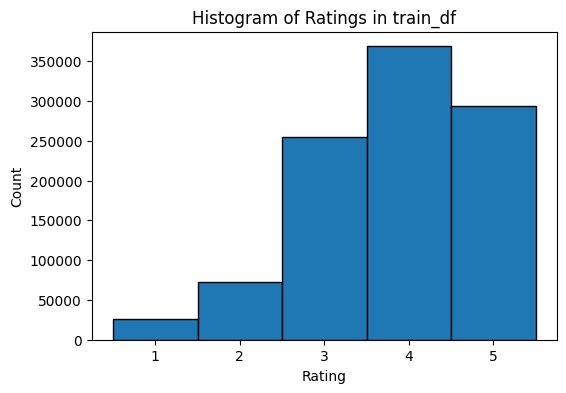

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.hist(train_df['rating'], bins=range(train_df['rating'].min(), train_df['rating'].max() + 2), edgecolor='black', align='left')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Histogram of Ratings in train_df')
plt.xticks(range(train_df['rating'].min(), train_df['rating'].max() + 1))
plt.show()

In [4]:
train_df['rating'].quantile(0.75)

5.0

In [5]:
shortest_path_distances = torch.load('m_step_trans_prob.pt')

In [6]:
shortest_path_distances[torch.isinf(shortest_path_distances)] = 0

In [8]:
from sklearn.metrics import mutual_info_score
from scipy.stats import pearsonr

# Extract distances for each (sid, pid) pair in train_df
sid_indices = valid_df['sid'].values
pid_indices = valid_df['pid'].values
distance_indices = (sid_indices, 10000 + pid_indices)
# Compute the difference vectors for each (sid, pid) pair in batches to avoid memory issues
batch_size = 100_000
num_samples = len(distance_indices[0])
distances_list = []

for start in tqdm(range(0, num_samples, batch_size)):
    end = min(start + batch_size, num_samples)
    sids = distance_indices[0][start:end]
    pids = distance_indices[1][start:end]
    diffs = shortest_path_distances[sids] - shortest_path_distances[pids]
    batch_distances = torch.norm(diffs, dim=1).cpu().numpy()
    distances_list.append(batch_distances)

distances = np.concatenate(distances_list)


ratings = valid_df['rating'].values

# Pearson correlation
corr, _ = pearsonr(ratings, distances)

# Mutual information (discretize distances for MI)
distances_discrete = np.digitize(distances, np.histogram_bin_edges(distances, bins='auto'))
mi = mutual_info_score(ratings, distances_discrete)

print(f"Pearson correlation: {corr}")
print(f"Mutual information: {mi}")

100%|██████████| 2/2 [00:06<00:00,  3.24s/it]

Pearson correlation: 0.15077465648466684
Mutual information: 0.016424156884687544


In [14]:
from sklearn.metrics import mutual_info_score
from scipy.stats import pearsonr

# Extract distances for each (sid, pid) pair in train_df
sid_indices = valid_df['sid'].values
pid_indices = valid_df['pid'].values
distance_indices = (sid_indices, 10000 + pid_indices)
# Compute the difference vectors for each (sid, pid) pair in batches to avoid memory issues
batch_size = 100_000
num_samples = len(distance_indices[0])


distances = shortest_path_distances[distance_indices].cpu().numpy()


ratings = valid_df['rating'].values

# Pearson correlation
corr, _ = pearsonr(ratings, distances)

# Mutual information (discretize distances for MI)
distances_discrete = np.digitize(distances, np.histogram_bin_edges(distances, bins='auto'))
mi = mutual_info_score(ratings, distances_discrete)

print(f"Pearson correlation: {corr}")
print(f"Mutual information: {mi}")

Pearson correlation: 0.12062344582814949
Mutual information: 0.01843930452334843


In [155]:
shortest_path_distances

tensor([[8.8959e-05, 1.6554e-04, 8.2357e-05,  ..., 1.1217e-04, 8.3060e-05,
         8.7622e-05],
        [8.9348e-05, 1.6627e-04, 8.2717e-05,  ..., 1.0980e-04, 8.1310e-05,
         8.5780e-05],
        [8.8903e-05, 1.6543e-04, 8.2305e-05,  ..., 1.1251e-04, 8.3310e-05,
         8.7886e-05],
        ...,
        [1.8606e-05, 3.3745e-05, 1.7288e-05,  ..., 5.3965e-04, 3.9925e-04,
         4.2063e-04],
        [1.8620e-05, 3.3771e-05, 1.7301e-05,  ..., 5.3956e-04, 3.9919e-04,
         4.2056e-04],
        [1.8640e-05, 3.3809e-05, 1.7320e-05,  ..., 5.3944e-04, 3.9910e-04,
         4.2047e-04]], device='cuda:0')

In [156]:
min_distances = distances.min()
max_distances = distances.max()
min_distances, max_distances

(np.float32(0.025555104), np.float32(0.026211845))

In [157]:
distance_indices[0].shape

(112819,)

In [158]:
ratings.shape

(112819,)

In [159]:
((shortest_path_distances < 1) * (shortest_path_distances > 0)).any()

tensor(True, device='cuda:0')

In [160]:
distances

array([0.02598737, 0.0259894 , 0.02594826, ..., 0.02598696, 0.02584133,
       0.02595665], shape=(112819,), dtype=float32)

In [161]:
shortest_path_distances

tensor([[8.8959e-05, 1.6554e-04, 8.2357e-05,  ..., 1.1217e-04, 8.3060e-05,
         8.7622e-05],
        [8.9348e-05, 1.6627e-04, 8.2717e-05,  ..., 1.0980e-04, 8.1310e-05,
         8.5780e-05],
        [8.8903e-05, 1.6543e-04, 8.2305e-05,  ..., 1.1251e-04, 8.3310e-05,
         8.7886e-05],
        ...,
        [1.8606e-05, 3.3745e-05, 1.7288e-05,  ..., 5.3965e-04, 3.9925e-04,
         4.2063e-04],
        [1.8620e-05, 3.3771e-05, 1.7301e-05,  ..., 5.3956e-04, 3.9919e-04,
         4.2056e-04],
        [1.8640e-05, 3.3809e-05, 1.7320e-05,  ..., 5.3944e-04, 3.9910e-04,
         4.2047e-04]], device='cuda:0')

In [162]:
(shortest_path_distances - np.eye(shortest_path_distances.shape[0]) < 1).all()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:
import pickle
with open("simplices.pkl", "rb") as f:
    simplices = pickle.load(f)

with open("simplices_val.pkl", "rb") as f:
    simplices_val = pickle.load(f)

In [ ]:
CHOSEN = 1

In [ ]:
ratings.shape, np.array(simplices[CHOSEN]).shape

((112819,), (1015368,))

In [ ]:
corr, _ = pearsonr(ratings, np.array(simplices[CHOSEN]))

# Mutual information (discretize distances for MI)
simplices_discrete = np.digitize(np.array(simplices[CHOSEN]), np.histogram_bin_edges(np.array(simplices[CHOSEN]), bins='auto'))
mi = mutual_info_score(ratings, simplices_discrete)

print(f"Pearson correlation: {corr}")
print(f"Mutual information: {mi}")

ValueError: `x` and `y` must have the same length along `axis`.

In [ ]:
simplices[1.0][0]

10998

In [ ]:
probs = [i for i in range(11)]

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class SimplicesSequenceDataset(Dataset):
    def __init__(self, simplices, probs, ratings):
        self.probs = np.array([p for p in probs])
        self.simplices = simplices
        self.ratings = ratings
        # Build (num_samples, num_probs) array
        self.sequences = np.stack([np.array(self.simplices[p]) for p in self.probs], axis=1)
        print(f"Shape of sequences: {self.sequences.shape}")
        assert self.sequences.shape[0] == len(self.ratings)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        # Return (sequence, rating)
        seq = self.sequences[idx]
        rating = self.ratings[idx]
        return torch.tensor(seq, dtype=torch.float32), torch.tensor(rating, dtype=torch.float32)

# Fix for probs: if it's a generator, convert to list of floats
if isinstance(probs, np.ndarray) and probs.dtype == object:
    probs_list = list(probs)
    if hasattr(probs_list[0], '__iter__'):
        probs_list = [float(x) for x in probs_list[0]]
    else:
        probs_list = [float(x) for x in probs_list]
else:
    probs_list = [float(x) for x in probs]

ratings = np.array(train_df['rating'].values)
dataset = SimplicesSequenceDataset(simplices, probs_list, ratings)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

Shape of sequences: (1015368, 11)


In [ ]:
ratings.shape

(1015368,)

In [ ]:
import torch.nn as nn
import torch.optim as optim

class SimpleCNN(nn.Module):
    def __init__(self, seq_len):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * seq_len, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = x.unsqueeze(1)  # (batch_size, 1, seq_len)
        x = torch.log1p(x )  # remove +2 next time
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x.squeeze(1)

# Get sequence length from dataset
seq_len = dataset[0][0].shape[0]
model = SimpleCNN(seq_len)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Prepare validation dataset and dataloader
class SimplicesSequenceDataset(Dataset):
    def __init__(self, simplices, probs, ratings):
        self.probs = np.array([p for p in probs])
        self.simplices = simplices
        self.ratings = ratings
        self.sequences = np.stack([np.array(self.simplices[p]) for p in self.probs], axis=1)
        assert self.sequences.shape[0] == len(self.ratings)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        rating = self.ratings[idx]
        return torch.tensor(seq, dtype=torch.float32), torch.tensor(rating, dtype=torch.float32)

valid_ratings = valid_df['rating'].values
valid_dataset = SimplicesSequenceDataset(simplices_val, probs_list, valid_ratings)
valid_dataloader = DataLoader(valid_dataset, batch_size=256, shuffle=False)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)


EPOCHS = 10
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for sequences, ratings in dataloader:
        sequences = sequences.to(device)
        ratings = ratings.to(device)
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, ratings)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * sequences.size(0)
    epoch_loss = running_loss / len(dataset)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss:.4f}")
    scheduler.step()

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for sequences, ratings in valid_dataloader:
            sequences = sequences.to(device)
            ratings = ratings.to(device)
            outputs = model(sequences)
            loss = criterion(outputs, ratings)
            val_loss += loss.item() * sequences.size(0)
    val_loss /= len(valid_dataset)
    print(f"Validation Loss: {val_loss:.4f}")

Epoch 1/10, Loss: 1.0408
Validation Loss: 1.0552
Epoch 2/10, Loss: 1.0324
Validation Loss: 1.0361
Epoch 3/10, Loss: 1.0308
Validation Loss: 1.0307
Epoch 4/10, Loss: 1.0300
Validation Loss: 1.0299
Epoch 5/10, Loss: 1.0292
Validation Loss: 1.0259
Epoch 6/10, Loss: 1.0285
Validation Loss: 1.0292
Epoch 7/10, Loss: 1.0277
Validation Loss: 1.0256
Epoch 8/10, Loss: 1.0272
Validation Loss: 1.0257
Epoch 9/10, Loss: 1.0265
Validation Loss: 1.0256
Epoch 10/10, Loss: 1.0262
Validation Loss: 1.0256


In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

ratings = np.array(train_df['rating'].values)
filtrations = np.stack([np.array(simplices[p]) for p in probs], axis=1)
X_train, X_val, y_train, y_val = train_test_split(np.log1p(filtrations )[:, 3:9], ratings, test_size=0.1)
reg = Ridge(alpha=1.0)
reg.fit(X_train, y_train)
rmse = mean_squared_error(y_val, reg.predict(X_val))
print(f"Linear RMSE on filtration features: {rmse:.3f}")

Linear RMSE on filtration features: 1.019


In [ ]:
filtrations.shape

(1015368, 11)

In [163]:
import numpy as np
print(np.std(np.log1p(filtrations ), axis=0))

[1.00691011e-10 1.37648182e-01 2.14944568e-01 2.67772703e-01
 3.02655116e-01 3.21832923e-01 3.23332583e-01 2.93695445e-01
 1.47356360e-01 2.56421331e-01 0.00000000e+00]


In [165]:
from sklearn.feature_selection import mutual_info_regression
ratings = np.array(train_df['rating'].values)
mi = mutual_info_regression(filtrations, ratings)
print(mi)

[0.0040343  0.         0.         0.         0.         0.
 0.         0.         0.         0.00086813 0.00217175]
